In [1]:
import os
from os.path import join, basename, dirname
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
# import plotly #allows interactive plotting
import contextily as ctx # back ground maps
import rasterio
import shapely

from shapely.ops import linemerge
from shapely.geometry import LineString, Point, shape, mapping
import fiona


In [2]:
usr_dir = os.getcwd()
while basename(usr_dir) != 'Users':
    temp = basename(usr_dir)
    usr_dir = dirname(usr_dir)
usr_dir += '/' + temp

gwfm_dir = usr_dir+'/Box/research_cosumnes/GWFlowModel/'
proj_dir = gwfm_dir+'Stream_seepage/'
dat_dir = proj_dir+'Stream_level_data/'

# Quick Map of Loggers

<AxesSubplot:>

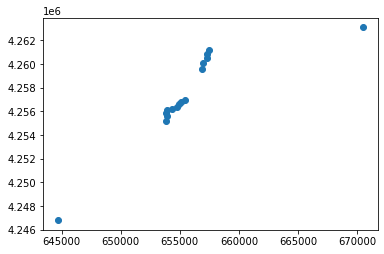

In [3]:
df = pd.read_csv(dat_dir+'/instream_sensor_latlong.csv')
rm_sp = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude,df.Latitude))
rm_sp.crs = 'epsg:4326'
rm_sp = rm_sp.to_crs('epsg:32610')

fig, ax =plt.subplots(figsize=(6,6))
rm_sp.plot(ax=ax)
# USGS. USImagery, USImageryTopo, USTopo; Esri. WorldImagery, WorldTopoMap
# ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs='epsg:26910', attribution=False)


In [4]:

dem_dir = gwfm_dir+ '/DEM_data'



# Get elevation of logger locations

In [5]:
# raster_name = dem_dir+'/USGS_ten_meter_dem/regional_10m.tif'
# raster_name = dem_dir+'/USGS_one_meter_dem/cropped_dem.tif'
# raster_name = dem_dir+'/HECRAS_dem/Terrain.Cos.tif'
# load 1M DEM
raster_name = dem_dir+'/HECRAS_dem/Terrain.Cos.reprojected.tif'

dem_f = rasterio.open(raster_name)
dem = dem_f.read(1)
xmin, xmax = dem_f.bounds[0], dem_f.bounds[2]
ymin, ymax = dem_f.bounds[1], dem_f.bounds[3]
 
# crop in-stream sensors to those covered by the 1m DEM
rm_t = rm_sp.cx[xmin:xmax, ymin:ymax]
rm_t['Easting'] = rm_t.geometry.x.values
rm_t['Northing'] = rm_t.geometry.y.values

point = rm_t.loc[:,['Easting','Northing']].values

with rasterio.open(raster_name) as src:
    rm_t['z_ft'] = [sample[0] for sample in src.sample(point)]

rm_t['z_m'] = rm_t.loc[:,'z_ft']*0.3048


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set 

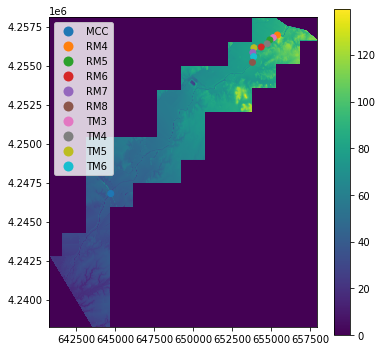

In [6]:
fig,ax=plt.subplots(figsize=(6,6))
rm_t.plot('Sensor', ax=ax, legend=True)

im = ax.imshow(dem, extent = [xmin,xmax,ymin,ymax],vmin=0)
fig.colorbar(im)

# plt.xlim(cr_xmin, cr_xmax )
# plt.ylim(cr_ymin, cr_ymax )

## Crop analysis to area with 1m DEM (Teichert to MCC)

In [160]:
# remove McConnell from teichert locations
rm_t = rm_t.loc[rm_t.Sensor != 'MCC']

# limit analysis to boundary box of stream sensors
cr_xmin, cr_ymin, cr_xmax, cr_ymax = rm_t.buffer(400).total_bounds


In [32]:
# Rivers and creeks in the larger area encompassing Cosumnes River in both South American and Cosumnes Subbasins
rivers = gpd.read_file(gwfm_dir+"/SFR_data/Sac_valley_rivers/Sac_valley_rivers.shp")
rivers = rivers.to_crs('EPSG:32610')
cr = rivers[rivers.GNIS_Name =='Cosumnes River']
# filter to DEM extents
cr = cr.cx[xmin:xmax, ymin:ymax]

# # crop cosumnes river line to t
# cr = cr.cx[cr_xmin:cr_xmax, cr_ymin:cr_ymax]

# Stream segments, there is a new segment each time two rivers/creeks join one another
cr_line = shapely.geometry.MultiLineString(cr.geometry.values)


In [161]:
rm_t

,Sensor,Type,Latitude,Longitude,geometry,Easting,Northing,z_ft,z_m
5,RM4,Level,38.447523,-121.219193,POINT (655400.950 4256972.451),655400.949544,4.256972e+06,76.21875,23.231476
6,TM3,Temperature,38.446011,-121.222305,POINT (655132.531 4256799.429),655132.530943,4.256799e+06,70.31250,21.431250
7,RM5,Level,38.444764,-121.224799,POINT (654917.593 4256656.807),654917.593135,4.256657e+06,71.31250,21.736050
8,TM4,Temperature,38.442525,-121.226872,POINT (654741.482 4256404.907),654741.481635,4.256405e+06,70.71875,21.555075
9,RM6,Level,38.440750,-121.231274,POINT (654361.002 4256200.514),654361.002130,4.256201e+06,69.00000,21.031200
10,TM5,Temperature,38.440389,-121.236643,POINT (653893.213 4256151.472),653893.212826,4.256151e+06,71.00000,21.640800
11,RM7,Level,38.437677,-121.237514,POINT (653822.958 4255849.100),653822.957871,4.255849e+06,68.18750,20.783550
12,TM6,Temperature,38.435267,-121.236959,POINT (653876.465 4255582.571),653876.464912,4.255583e+06,66.03125,20.126326
13,RM8,Level,38.431994,-121.237903,POINT (653801.013 4255217.782),653801.013375,4.255218e+06,63.43750,19.335751


<AxesSubplot:>

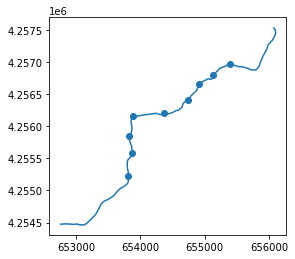

In [162]:
cr.cx[cr_xmin:cr_xmax, cr_ymin:cr_ymax].length.sum()/100
fig,ax = plt.subplots()
cr.cx[cr_xmin:cr_xmax, cr_ymin:cr_ymax].plot(ax=ax)
rm_t.plot(ax=ax)

# Get elevation of "thalweg"
Thalweg here is elevation at shapefile location.

In [33]:


geom = shape(cr_line)

# # length of the LineString
length = int(geom.length)
sfr_sp = gpd.GeoDataFrame(pd.DataFrame(np.zeros((length,1)),columns=['id']))
sfr_sp['geometry'] = shapely.geometry.Point(0,0)
# enumerate keeps track of the count in addition to the object being iterated on
for i, distance in enumerate(range(0, length, 1)):
    point = geom.interpolate(distance)
    sfr_sp.loc[i,'geometry'] = point
    sfr_sp.loc[i,'id'] = i

In [34]:
sfr_sp['Easting'] = sfr_sp.geometry.x.values
sfr_sp['Northing'] = sfr_sp.geometry.y.values

point = sfr_sp.loc[:,['Easting','Northing']].values

with rasterio.open(raster_name) as src:
    sfr_sp['z_ft'] = [sample[0] for sample in src.sample(point)]
    
sfr_sp['z_m'] = sfr_sp.loc[:,'z_ft']*0.3048


## Convert the parallel lines to points 

In [10]:
# using lengths on the parallel lines won't work because around bends one will become offset
# one option is to pick a point on the line to interpolate and pick one point a little further 
# then do parallel offset to that line and create the transect that way

In [35]:

geom = linemerge(cr.geometry.values)
# geom = geom.simplify(10)
# how often to interpolate a point
dline = 100
# # length of the LineString
length = int(geom.length)

transects = pd.DataFrame(np.zeros((int(np.ceil(length/dline)),1)), columns = ['line'])
transects['geometry'] = LineString([(0,0),(0,1)]) #initiate LineString geometry column

# 300 meter width so that 100 meter can be cutoff to have 200m around true thalweg
xs_width = 300
for i, distance in enumerate(range(0, int(length), dline)):
    short_line = LineString([geom.interpolate(distance),geom.interpolate(distance+dline)])
    geom_left = short_line.parallel_offset(xs_width/2,'left', resolution = 32, join_style = 2)
    geom_right = short_line.parallel_offset(xs_width/2,'right', resolution = 32, join_style = 2)
    perp_line = LineString([geom_left.boundary[1], geom_right.boundary[0]])
    transects.loc[i,'geometry'] = perp_line

<AxesSubplot:>

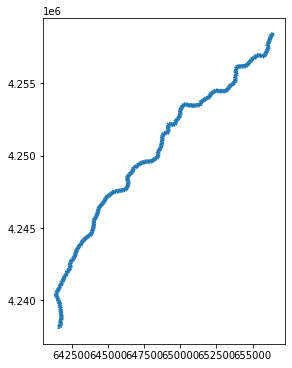

In [36]:
transg = gpd.GeoDataFrame(transects)
transg = transg.drop_duplicates('geometry')
transg['line'] = np.arange(0,len(transg))
# check cross section lines are paralle
fig,ax=plt.subplots(figsize=(6,6))
transg.plot(ax=ax)
cr.plot(ax=ax)

## Sample elevations for each point
Can sample elevation by converting all lines to points then sampling each point or by sampling one line at a time.

In [37]:
# # how often to interpolate a point in a XS
dline = 1

xs_all = gpd.GeoDataFrame(pd.DataFrame(columns=['xs_num','dist_from_right_m','geometry']))
xs = gpd.GeoDataFrame(pd.DataFrame(np.zeros((int(xs_width/dline),2)), columns=['xs_num','dist_from_right_m']))


for j in np.arange(0,len(transg)):
    xs['geometry'] = Point([(0,0)])
    xs['xs_num'] = j
    
    # pick one geometry at a time
    geom = transg.iloc[j].geometry

    # # # length of the LineString
    length = int(geom.length)
    # create discrete points for each lien
    for i, distance in enumerate(range(0, int(length), dline)):
        point = geom.interpolate(distance)
        xs.loc[i,'geometry'] = point
        xs.loc[i,'dist_from_right_m'] = i
    # append individual cross section to all dataframe
    xs_all = xs_all.append( xs)

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all = xs_all.append( xs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\2156887260.py:23

In [38]:
xs_all.crs='epsg:32610'
xs_all['Easting'] = xs_all.geometry.x
xs_all['Northing'] = xs_all.geometry.y
point = xs_all.loc[:,['Easting','Northing']].values

with rasterio.open(raster_name) as src:
    xs_all['z_ft'] = [sample[0] for sample in src.sample(point)]

xs_all['z_m'] = xs_all.loc[:,'z_ft']*0.3048



In [146]:
# limit analysis to boundary box of stream sensors
# cr_xmin, cr_ymin, cr_xmax, cr_ymax = rm_t.buffer(400).total_bounds

# # crop cosumnes river line to t
# cr = cr.cx[cr_xmin:cr_xmax, cr_ymin:cr_ymax]

# filter xs_all to the needed area
# xs_nums = xs_all.cx[cr_xmin:cr_xmax, cr_ymin:cr_ymax].xs_num.unique()

# remove any NA values picked up from DEM raster
xs_all.loc[xs_all['z_ft']==-9999,['z_ft','z_m']] = np.nan
xs_all.index = np.arange(0,len(xs_all))

# need to drop XS where there are a lot of NAs (>250)
xs_num_full = xs_all.xs_num.unique()[(xs_all.groupby('xs_num').count()['z_ft']>250).values]
xs_all = xs_all[xs_all.xs_num.isin(xs_num_full)]

# clean xs to only center 200 m out from true thalweg rather than NHD line
xs_all_cln = gpd.GeoDataFrame()
# correct XS points by those that were chosen for final XS
for n in xs_all.xs_num.unique():
    mid = xs_all.loc[xs_all.xs_num==n,'z_m'].iloc[int(xs_width/2)-50:int(xs_width/2)+50].idxmin()
    mid_vals = xs_all.loc[mid-100:mid+99]
    xs_all_cln = xs_all_cln.append(mid_vals)
# clean up distance from right
xs_all_cln['dist_from_right_m'] = np.tile(np.arange(0,200), len(xs_all_cln.xs_num.unique()))


C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalde

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalde

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalde

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalde

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalde

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalde

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalde

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_2292\4095818107.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xs_all_cln = xs_all_cln.append(mid_vals)
C:\Users\ajcalde

In [147]:
# convert to dataframe for creating table of XS
xs_all_df = pd.DataFrame(xs_all_cln.copy())
# pivot based on XS number and save only elevation in z_m
xs_all_df = xs_all_df.pivot_table(index='dist_from_right_m',columns='xs_num',values='z_m')


In [148]:
# save point data and XS
xs_all_cln.drop(['geometry'],axis=1).to_csv(dat_dir+'/XS_point_elevations.csv')
xs_all_df.to_csv(dat_dir+'/Elevation_by_XS_number_meters.csv')


In [141]:

# convert to dataframe for easier plotting
# xs_all_df = pd.DataFrame(xs_all)
# # pivot based on XS number and save only elevation in z_m
# xs_all_df = xs_all_df.pivot_table(index='dist_from_right_m',columns='xs_num',values='z_m')
# xs_all_df.to_csv('Elevation_by_XS_number_meters.csv')
# xs_all_df.plot()
# plt.legend(ncol=4, loc=(1,0.01), title='XS Number')


In [151]:
# validate that the XS minimums tend to be around the center of the XS, most are within 20-30 meters of center of sampled line
# xs_all_df.idxmin().plot()

In [142]:
# xs_df_cln = xs_all_df.copy()[0:200]
# n=0
# for n in xs_all_df.columns:
#     mid = int(xs_all_df.loc[:,n].idxmin())
#     midvals = xs_all_df.loc[mid-100:mid+100, n].values
#     xs_df_cln.loc[:,n] = midvals
# # xs_all_df[xs_all_df.idxmin().values-100:xs_all_df.idxmin().values+100]
# xs_df_cln.plot()
# plt.legend(ncol=4, loc=(1,0.01), title='XS Number')
# xs_df_cln.to_csv('Elevation_by_XS_number_meters.csv')


<AxesSubplot:>

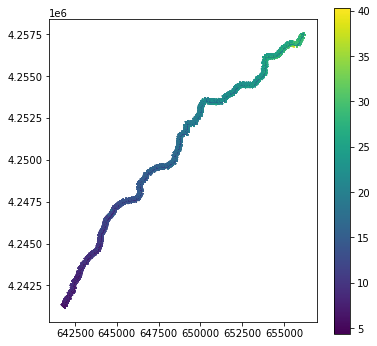

In [143]:
fig,ax=plt.subplots(figsize=(6,6))
xs_all.plot('z_m', markersize=0.2,legend=True,ax=ax)